In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('dataset.csv',usecols=['date on production','production'])

In [3]:
data.head()

,date on production,production
0,3/1/2018,5614.947951
1,7/1/2014,2188.836707
2,8/1/2018,1450.033022
3,1/1/2012,1060.764407
4,1/1/2012,607.530385


In [4]:
data.shape

(1000, 2)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date on production  1000 non-null   object 
 1   production          1000 non-null   float64
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


<Figure size 2000x400 with 0 Axes>

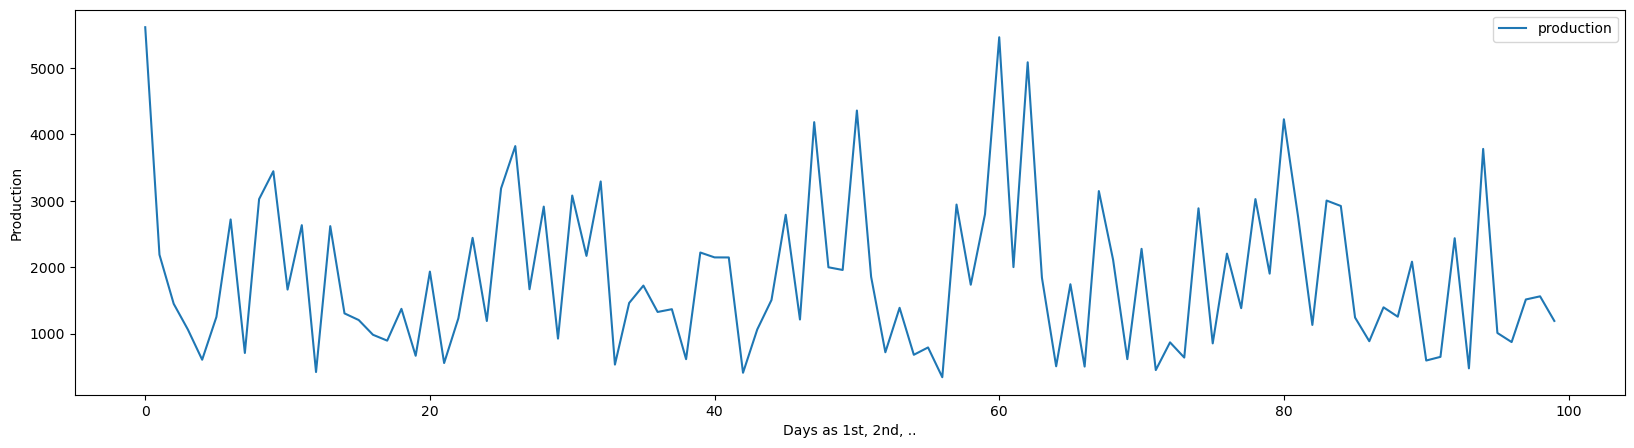

In [6]:
plt.rcParams['figure.figsize']=(20,5)
plt.figure(figsize=(20,4))
data[:100].plot()
plt.xlabel('Days as 1st, 2nd, ..')
plt.ylabel('Production')
plt.show()

In [13]:
# change date on production to datetime
data['date on production'] = pd.to_datetime(data['date on production'])

In [61]:
data.isna().sum()

date on production    0
production            0
dtype: int64

In [17]:
data.dtypes

date on production    datetime64[ns]
production                   float64
dtype: object

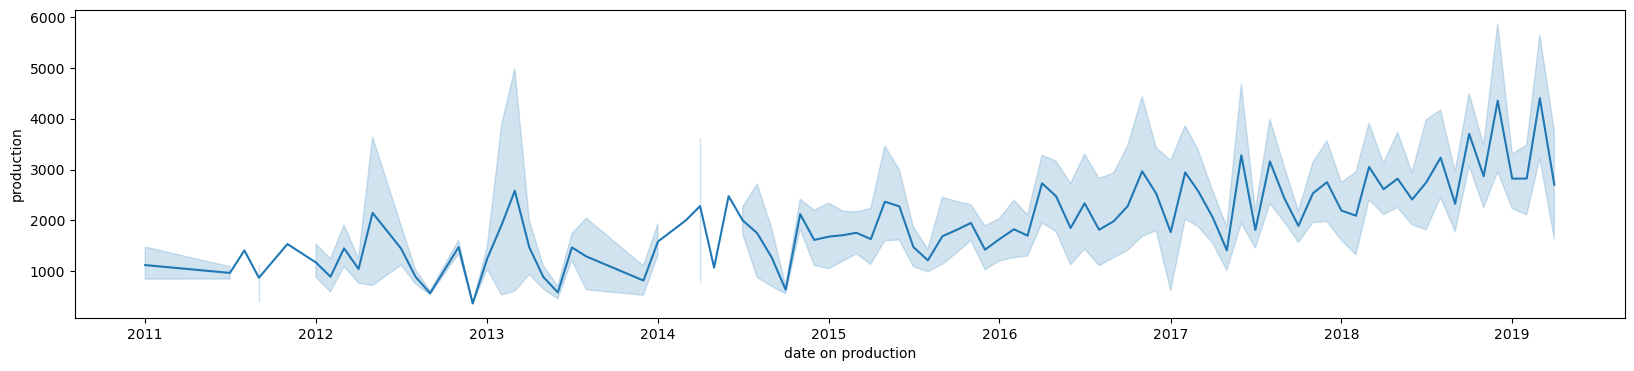

In [20]:
plt.figure(figsize=(20,4))
sns.lineplot(x=data['date on production'],y=data['production'])
plt.show()



## Split the data into train and test set

In [7]:
prod_data = data['production'].tolist() # change dataframe to list
np.random.seed(42)
data_length = len(prod_data) # check l
split_ratio = 0.7 # 70% train set and 30% test set
train_length = round(data_length * split_ratio)
test_length = data_length-train_length

print("Length of Data: ",data_length)
print("length of train set: ",train_length)
print("length of test set: ",test_length)

Length of Data:  1000
length of train set:  700
length of test set:  300


In [8]:
# divide the data

train_data = prod_data[:train_length]
test_data = prod_data[train_length:]
# print length of train and test data
len(train_data), len(test_data)

(700, 300)

## Normalization of data

In [9]:
# change the minmax to standardscaler

from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler =StandardScaler() # scale the data between  the range of 0 and 1

train_scaled = scaler.fit_transform(np.array(train_data).reshape(-1,1))
train_scaled = train_scaled.flatten() ## combine all arrays

test_scaled = scaler.fit_transform(np.array(test_data).reshape(-1,1))
test_scaled = test_scaled.flatten()

In [10]:
train_scaled[:10]

array([ 2.75330394,  0.18894245, -0.36403426, -0.65539241, -0.99462712,
       -0.51255198,  0.58648092, -0.91847676,  0.81574767,  1.12985363])

In [11]:
test_scaled[:10]

array([-1.06148515, -0.41079431, -0.6922051 , -1.05803481, -0.85647961,
        0.22486163,  0.39353155,  0.64518075,  1.13285656, -0.01692184])

## Create windows of the dataset

In [12]:
# create a function to process the data into 50 days look back slices
def windows_dataset(data, windows_size):
    X,y = [],[]
    for i in range(len(data)-window_size-1):
        X.append(data[i:(i+window_size)])
        y.append(data[i+window_size])
    return np.array(X),np.array(y)


window_size = 50

# create 50 days look back slices on train  and test data
x_train,y_train = windows_dataset(train_scaled,window_size)

x_test,y_test = windows_dataset(test_scaled,window_size)


In [13]:
x_train

array([[ 2.75330394,  0.18894245, -0.36403426, ...,  1.68324276,
         0.04742531,  0.01709408],
       [ 0.18894245, -0.36403426, -0.65539241, ...,  0.04742531,
         0.01709408,  1.81417665],
       [-0.36403426, -0.65539241, -0.99462712, ...,  0.01709408,
         1.81417665, -0.06032255],
       ...,
       [-0.40898503, -0.65995632,  1.85663297, ...,  0.51193497,
        -0.37111534, -0.91857491],
       [-0.65995632,  1.85663297, -0.98053012, ..., -0.37111534,
        -0.91857491, -0.7465769 ],
       [ 1.85663297, -0.98053012, -0.81154619, ..., -0.91857491,
        -0.7465769 , -0.4952246 ]])

## Train the model

In [14]:
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,BaggingRegressor,GradientBoostingRegressor,HistGradientBoostingRegressor
from sklearn.svm import SVR,LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

#### model evaluation function

In [15]:
# model evaluation function

def evaluate_model(model,X_train,y_train,X_test,y_test):
    model = model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    mae = print("Mean Absolute Error:",mean_absolute_error(y_test,y_pred))
    mse = print("Mean Squared Error: ",mean_squared_error(y_test,y_pred))
    rmse= print("Root Mean Squared Error: ",np.sqrt(mean_squared_error(y_test,y_pred)))
    r2score =r2_score(y_test,y_pred)
    print("R2 Score: ",r2score)
    y_test = scaler.inverse_transform(y_test.reshape(-1,1))
    y_pred = scaler.inverse_transform(y_pred.reshape(-1,1))
    
    # plot the actual vs predicted price
    
    plt.plot(y_test,label='y_test')
    plt.plot(y_pred, color='orange',label='y_pred')
    plt.xlabel("Days")
    plt.ylabel("Oil Production")
    plt.legend()
    plt.show()
    
    return 
    

In [16]:
rf =RandomForestRegressor()
adr =AdaBoostRegressor()
bgr =BaggingRegressor()
gbr =GradientBoostingRegressor()
hgr = HistGradientBoostingRegressor()
svr = SVR()
lsvr = LinearSVR()
lr =LinearRegression()
ridge =Ridge()
knn =KNeighborsRegressor()
dtree = DecisionTreeRegressor()

Model name:  RandomForestRegressor()
Mean Absolute Error: 0.8011022637248721
Mean Squared Error:  1.1053150168774983
Root Mean Squared Error:  1.05133962965233
R2 Score:  -0.08946592585376889


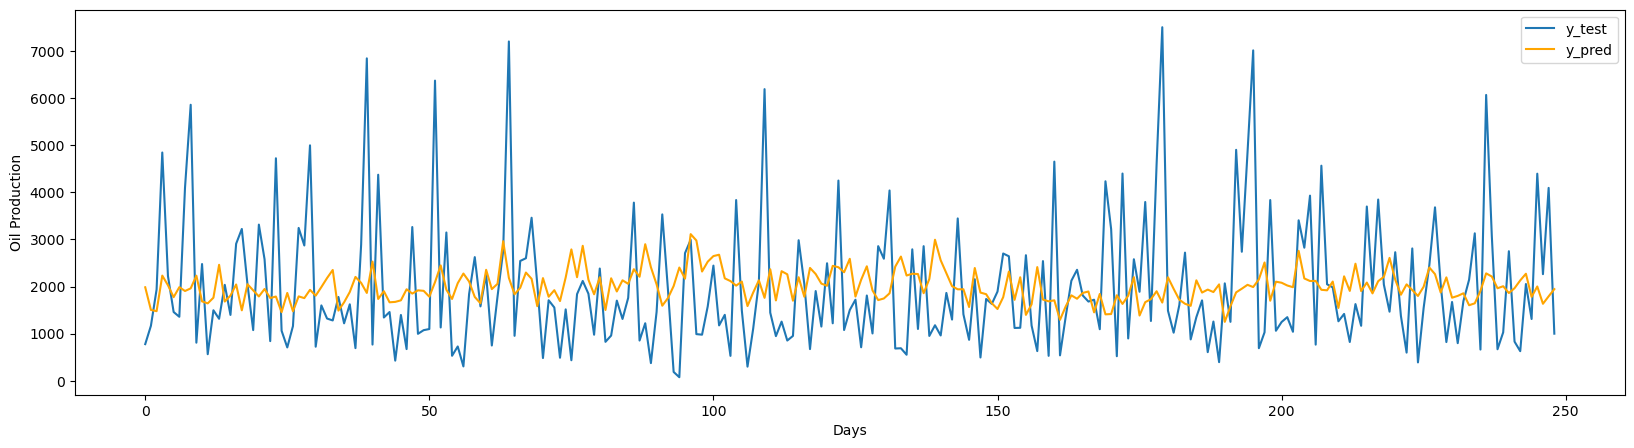

Model name:  AdaBoostRegressor()
Mean Absolute Error: 0.876652032107354
Mean Squared Error:  1.1221176088813716
Root Mean Squared Error:  1.0593005281228607
R2 Score:  -0.10602758581018268


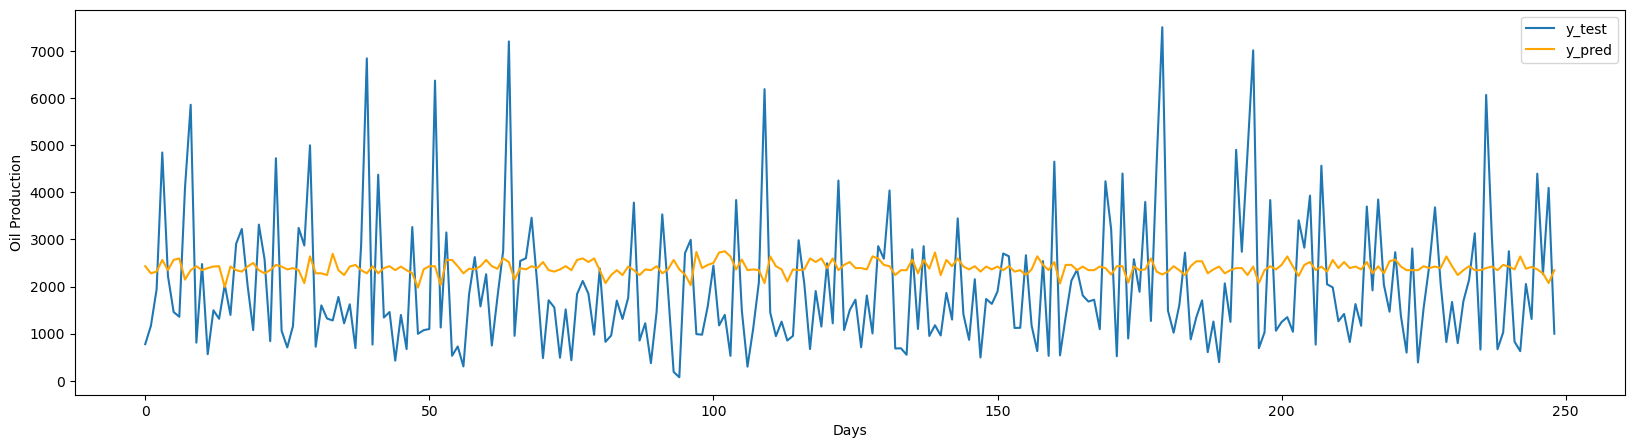

Model name:  BaggingRegressor()
Mean Absolute Error: 0.8172220507060401
Mean Squared Error:  1.1635646982472556
Root Mean Squared Error:  1.0786865616328294
R2 Score:  -0.14688036614922995


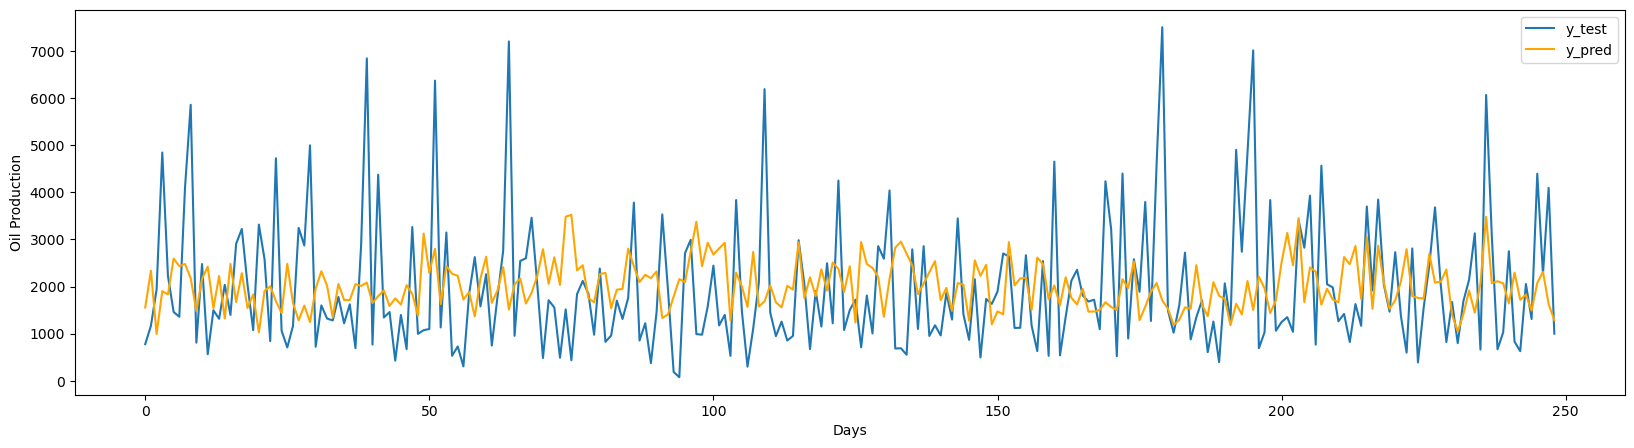

Model name:  GradientBoostingRegressor()
Mean Absolute Error: 0.8247063749641892
Mean Squared Error:  1.1814850453773549
Root Mean Squared Error:  1.0869613817322834
R2 Score:  -0.16454375376235442


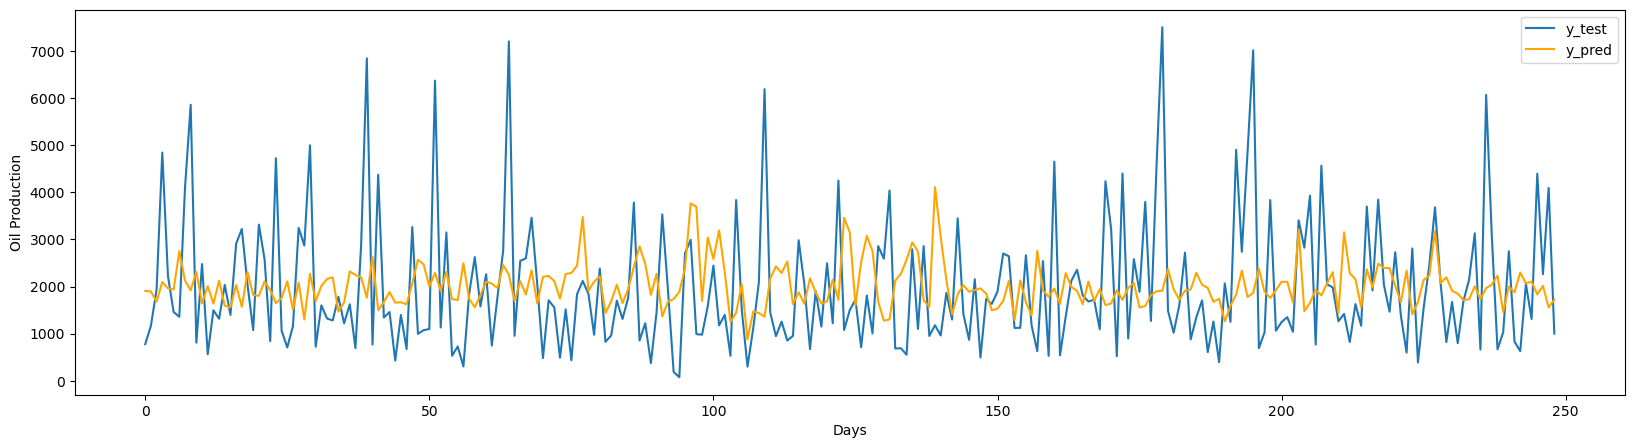

Model name:  HistGradientBoostingRegressor()
Mean Absolute Error: 0.8299053165167707
Mean Squared Error:  1.1669876332816882
Root Mean Squared Error:  1.080272018188793
R2 Score:  -0.1502542197832466


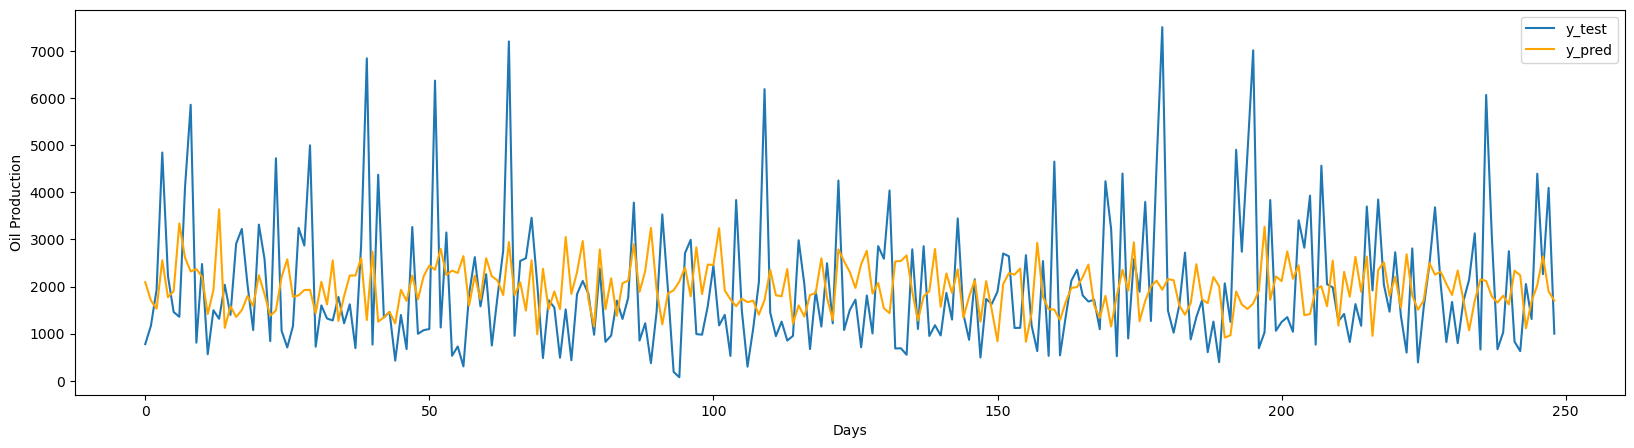

Model name:  LinearRegression()
Mean Absolute Error: 0.821698488536348
Mean Squared Error:  1.1018157530215065
Root Mean Squared Error:  1.0496741175343454
R2 Score:  -0.08601683787571468


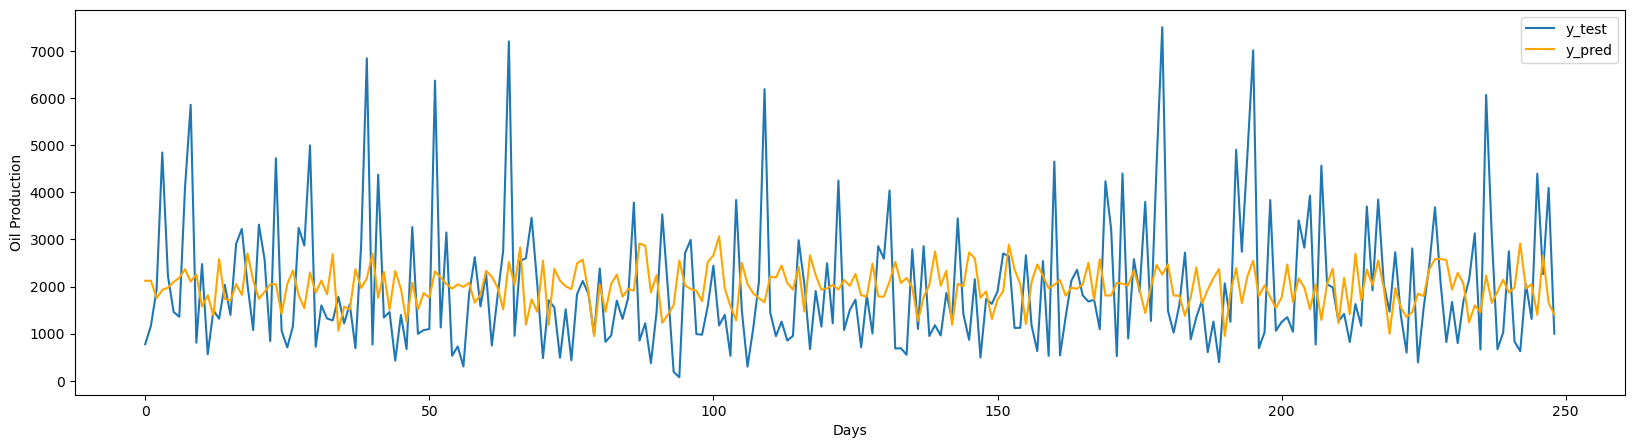

Model name:  Ridge()
Mean Absolute Error: 0.8215220841090257
Mean Squared Error:  1.1015121000176327
Root Mean Squared Error:  1.0495294660073307
R2 Score:  -0.08571753894649348


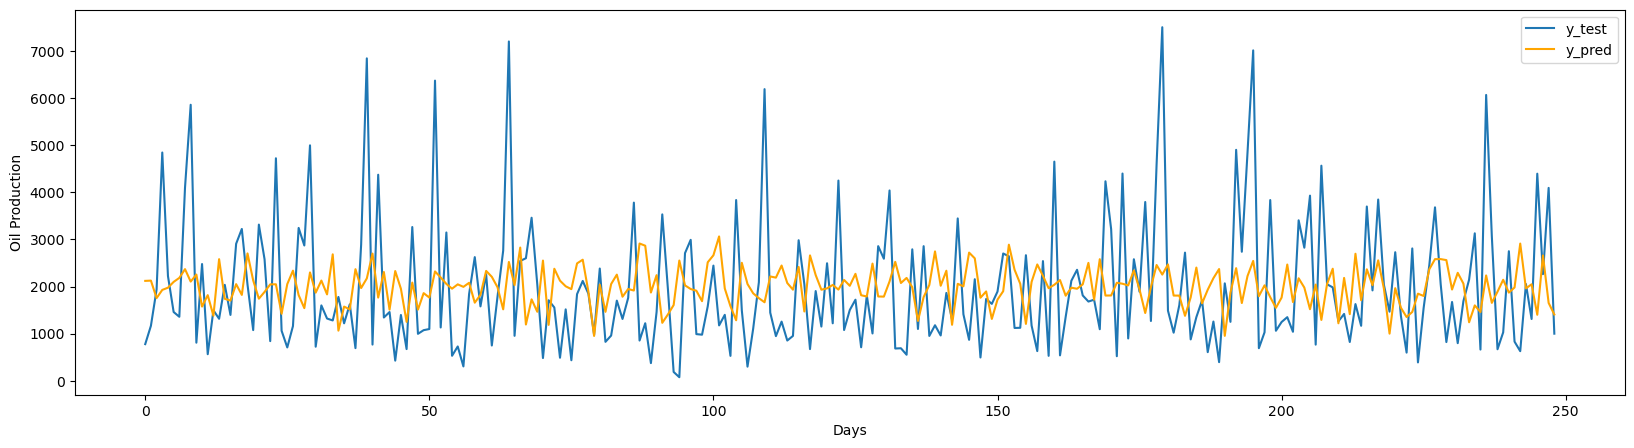

Model name:  KNeighborsRegressor()
Mean Absolute Error: 0.8594529036993497
Mean Squared Error:  1.228611077990114
Root Mean Squared Error:  1.1084272993706508
R2 Score:  -0.21099404708897151


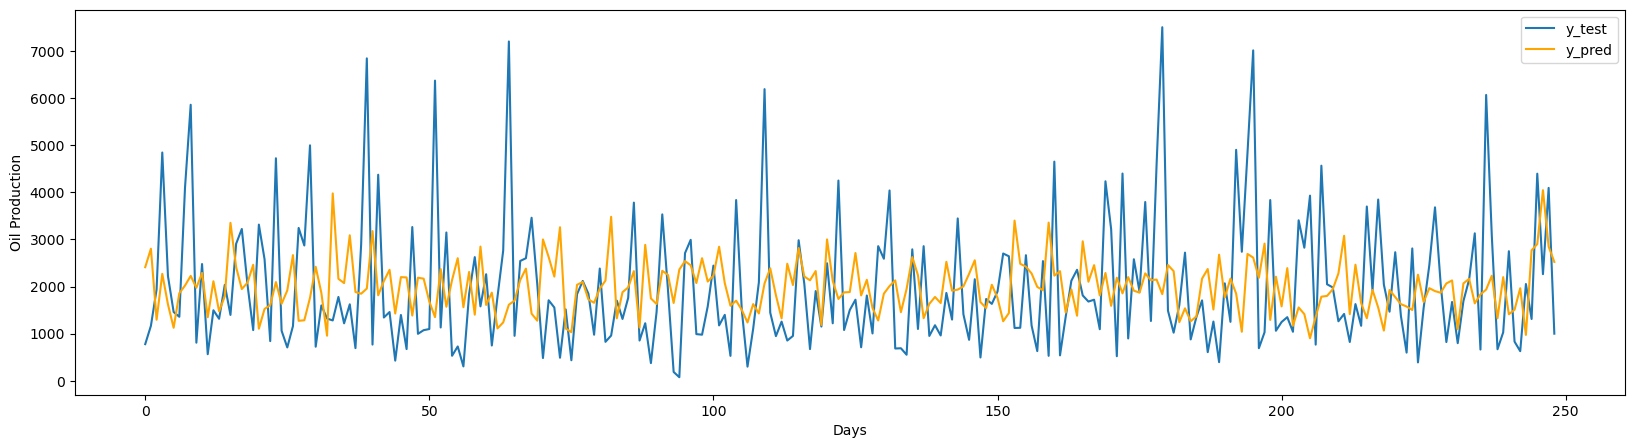

Model name:  LinearSVR()
Mean Absolute Error: 0.7876409730366258
Mean Squared Error:  1.1907270808424077
Root Mean Squared Error:  1.091204417532484
R2 Score:  -0.1736532678564917


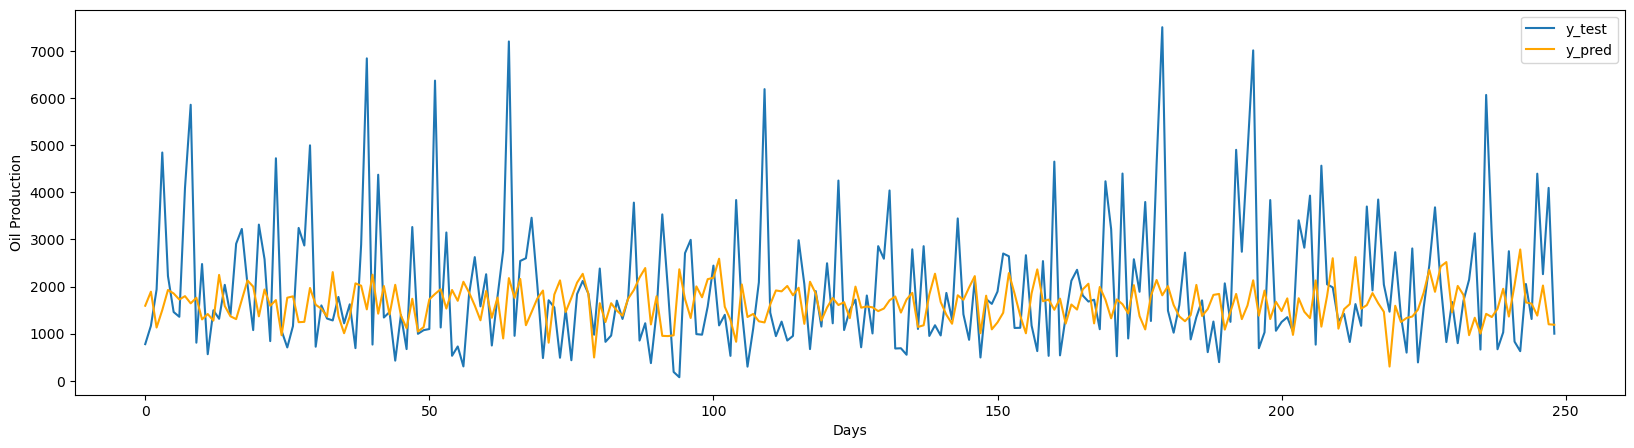

Model name:  DecisionTreeRegressor()
Mean Absolute Error: 1.0225118621699365
Mean Squared Error:  1.929129627036855
Root Mean Squared Error:  1.3889311095359824
R2 Score:  -0.9014678739722362


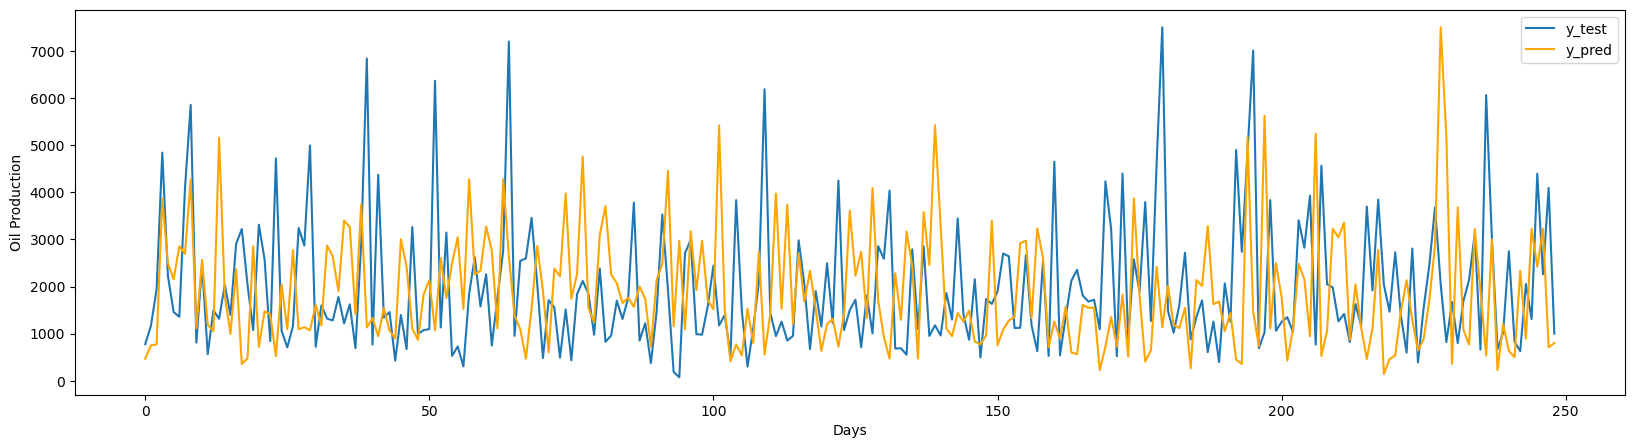

Model name:  SVR()
Mean Absolute Error: 0.7744406643785646
Mean Squared Error:  1.1092300604289473
Root Mean Squared Error:  1.0531999147497817
R2 Score:  -0.09332483167012762


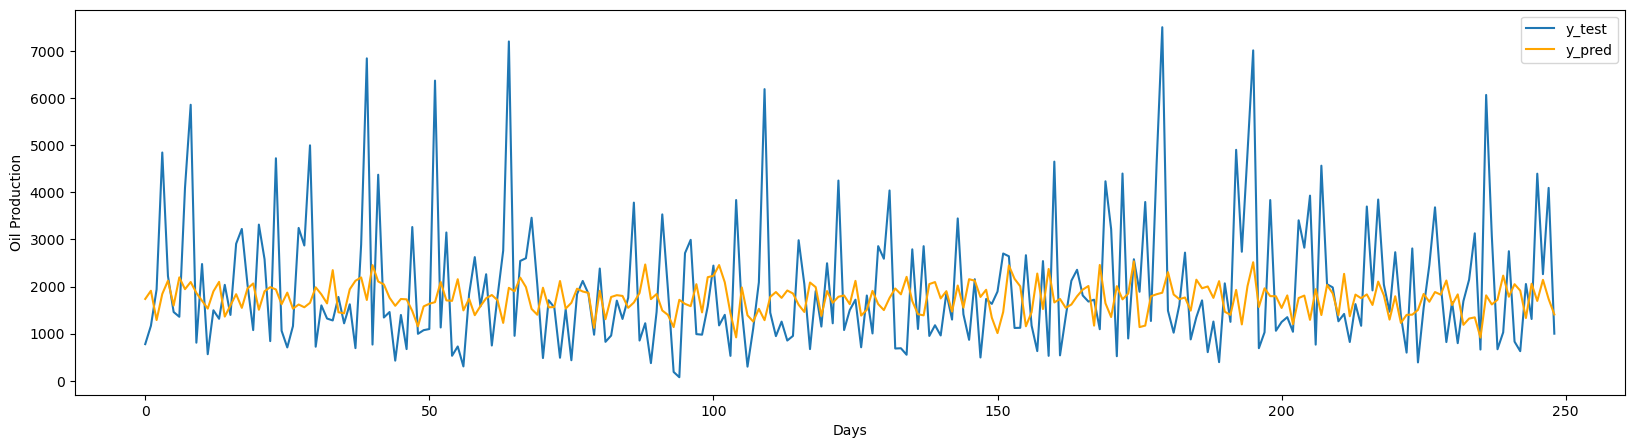

In [17]:
# list of models
model = [rf,adr,bgr,gbr,hgr,lr,ridge,knn,lsvr,dtree,svr]
for i in model:
    print('Model name: ',i)
    evaluate_model(i, x_train,y_train,x_test,y_test)

In [18]:
(x_train.shape[1], 1)

(50, 1)

# Use the BrentOilPrice model to predict production

In [47]:
df = data['production'].tolist() # convert the dataframe to list

### Normalize the data

In [48]:
## Scale the data for prediction
scaler = joblib.load('LR_model_Scaler.pkl')

new_data = scaler.fit_transform(np.array(df).reshape(-1,1))
new_data = new_data.flatten()

In [49]:
## create windows of the dataset

def window_dataset(data,window_size):
    X,y = [],[]
    for i in range(len(data)-window_size-1):
        X.append(data[i:(i+window_size)])
        y.append(data[i+window_size])
    return np.array(X),np.array(y)

In [50]:
window_size = 50
new_X,new_y = window_dataset(new_data,window_size)

## Load the model

In [51]:
model =joblib.load('BrentOilPrice_lr_model.pkl')


### Make prediction with model

In [53]:
predicted_prod = model.predict(new_X)

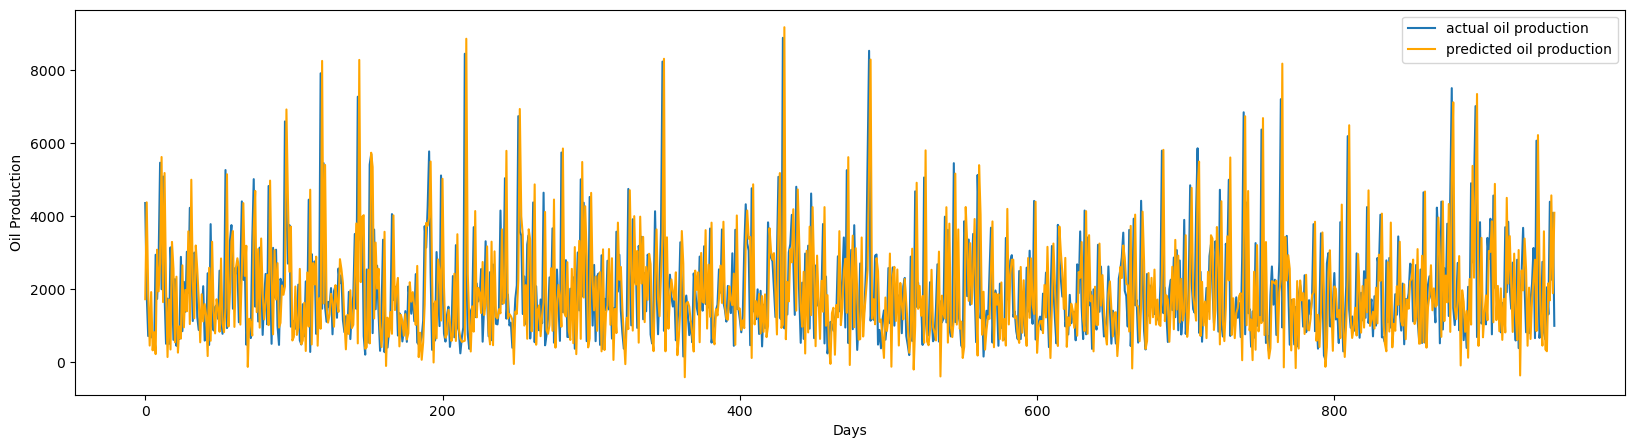

In [54]:
new_y = scaler.inverse_transform(new_y.reshape(-1,1))
predicted_prod = scaler.inverse_transform(predicted_prod.reshape(-1,1))
    
# plot the actual vs predicted price
    
plt.plot(new_y,label='actual oil production')
plt.plot(predicted_prod, color='orange',label='predicted oil production')
plt.xlabel("Days")
plt.ylabel("Oil Production")
plt.legend()
plt.show()

## Check Prediction R2 score

In [55]:
r2 =r2_score(new_y,predicted_prod)
print("R2 Score: ",r2)

R2 Score:  -1.1579083360140436
